In [2]:
%pylab inline
import pandas as pd
import seaborn as sns
from __future__ import division
import datetime

# import the custom machine learning helper functions that are in a separate module in the same folder
import mltl

sns.set_style('white')

Populating the interactive namespace from numpy and matplotlib


#1. Data Import and Basic Feature Selection

The following code imports the dataset used in the previous projects and calls the dataframe **bd**. It also sets a number of lists for each feature set given that the full data set has many features that will not be used for our current data exploration.

In [3]:
# import the merged and cleaned data set from its csv
bd = pd.read_csv('buildings_clean.csv', low_memory=False)
bd = bd.set_index('BBL')
bd = bd[bd.property_type == 'Multifamily Housing']

# set the various feature sets as well
targets = ['EUIwn', 'EUI', 'EUIwn_norm']
orig_class_dummies = [u'borough', u'zip', u'property_type']
orig_class = [u'water_method']
orig_cont = [u'water_ft2', u'energy_star', u'GHG', u'floor_area', u'no_buildings']
pluto_class_dummies = [u'BldgClass', u'LandUse', u'OwnerType', u'AreaSource', u'Ext', u'ProxCode', \
                       u'IrrLotCode', u'LotType', u'BsmtCode']
pluto_class = ['Landmarked', 'BuiltCode', 'Altered']
pluto_cont = [u'Easements', u'LotArea', u'BldgArea', u'ComArea', u'ResArea', u'OfficeArea', \
              u'RetailArea', u'GarageArea', u'StrgeArea', u'FactryArea', u'OtherArea', \
              u'NumBldgs', u'NumFloors', u'UnitsRes', u'UnitsTotal', u'LotFront', u'LotDepth', \
              u'BldgFront', u'BldgDepth', u'AssessLand', u'AssessTot', u'ExemptLand', u'ExemptTot', \
              u'BuiltFAR', u'MaxAllwFAR', 'YearBuilt', 'YearLastWork', u'PerComArea', u'PerResArea', \
              u'PerOfficeArea', u'PerRetailArea', u'PerGarageArea', u'PerStrgeArea', u'PerFactryArea',\
              u'PerOtherArea']

Now that we have the data imported, we want to fully explore all the possible classification variables. To do this, we make all the **pluto_class_dummy** features, which contain various classification variables, in to unique dummy variables and save the list of these new dummy variables to the **dummies** list.

In [4]:
print "Start columns and rows:", (len(bd.columns), len(bd))

# join all the possible dummy variables to the building data
dummies = pluto_class
for col in pluto_class_dummies:
    dm = pd.get_dummies(bd[col], prefix=col)
    dummies = dummies + list(dm.columns)
    bd = bd.join(dm)

print "End columns and rows:", (len(bd.columns), len(bd))

# create the main feature list for running regressions
features = pluto_cont + dummies
print
print "Possible features for regression:", len(features)

Start columns and rows: (190, 7475)
End columns and rows: (290, 7475)

Possible features for regression: 138


#2. Regression Tree Exploration

The previous project explored an OLS regression based on adding one variable at a time. In order to more quickly explore the expanded feature set of 188 continuous and dummy variables, we will use a regression tree.

Our initial exploration is more interested in what variables are the most important, ranking the features using the normalized Gini importance. The decision tree is not optimized, as this is only being used as a quick way to see what the regression tree ranks as important.

In [5]:
# Import the required libraries
from sklearn import tree, metrics, cross_validation, linear_model, feature_selection

# test the new features in the regression tree
X = bd[features]
y = bd.EUIwn
tr = tree.DecisionTreeRegressor()
tr.fit(X, y)

# get the feature importance and print the top 20
feat_imp = pd.DataFrame({'features': features, 
                         'importance': tr.feature_importances_}).sort('importance', ascending=False)
feat_imp.head(20)

,features,importance
25,YearBuilt,0.113692
19,AssessLand,0.072315
23,BuiltFAR,0.059820
15,LotFront,0.055714
12,NumFloors,0.043103
17,BldgFront,0.039059
26,YearLastWork,0.036598
20,AssessTot,0.036296
16,LotDepth,0.034613
4,ResArea,0.031656


###Analysis of Important Features
Of the top 20 features in our regression tree, most are continuous and have rather self-explanitory names. However, the features ranked number 1, 2, and 7 are new dummies with the following meanings:

**1. LandUse_05:**   Commercial & Office Buildings

**2. BldgClass_l1:** HOSPITALS AND HEALTH: Hospitals, Sanitariums, Mental Institutions

**7. LandUse_08:**   Public Facilities & Institutions

The first two most important variables confirm our initial data exploration. Commercial buldings have different EUI than residential buildings, and Hospitals are particularly high users and different than other commercial buildings. It is also interesting to see that public facilities also have different usage characteristics.

The **YearBuilt** and **YearLastWork** are similar in character, as are **AssesLand** and **AssesTot**. The rest of the important features are some form of the size of the building, as well as the combination of size and building type, which relates mainly to the first two features. In general we see that the most imporant characteristics, in order are:

1. Is it Commercial?
2. Is it a Hospital?
3. When was it built?
4. What is the value of the building/land?
5. How big is the building?

###Comparison to OLS Regression
It is worth doing a quick check to see how the features selected by the regression tree as important compare to the previous work we did on OLS. In general, the main categories are consistent, and as shown in the following code section, the R2 of the model approaches a similar level of 0.4 that we got with our previous project as we add more features.

In [6]:
# see how r2 changes by feature importance 
fts = list(feat_imp.features)

# creat a linear regression classifier
lm = linear_model.LinearRegression()
y = bd[['EUIwn']]

# get the r2 for the regression as each feature is added in order of importance
scores = []
for i in range (1, len(fts)):
    X = bd[fts[0:i]]
    lm.fit(X,y)
    scores.append(metrics.r2_score(y, lm.predict(X)))

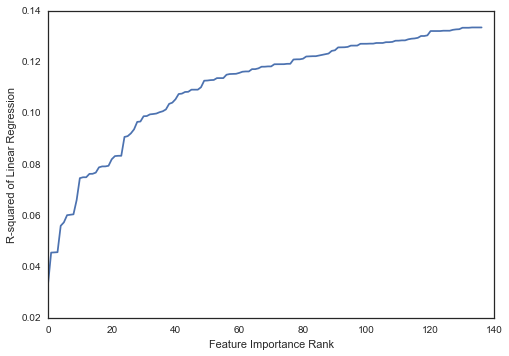

In [7]:
# print the plot
plt.figure()
plt.plot(scores)
plt.xlabel("Feature Importance Rank")
plt.ylabel("R-squared of Linear Regression")
plt.show()

###Optimization and Cross-validation

In [8]:
# import relevant libraries
from sklearn import metrics, cross_validation

# create the X and y
X = bd[features]
y = bd[['EUIwn_norm']]

# output the r2 for a crossvalidation of decision tree regressors with increasing depth
scores = []
for i in range(2, 20):
    tr = tree.DecisionTreeRegressor(max_depth=i, random_state=1234)
    scores.append(cross_validation.cross_val_score(tr, X, y, cv=5, scoring='r2'))
scores

[array([ 0.05055421,  0.09738154,  0.01415126,  0.05860027,  0.0261208 ]),
 array([ 0.03020421,  0.09380051,  0.0216779 ,  0.0616584 ,  0.03997688]),
 array([ 0.06085918,  0.03634726,  0.0242317 ,  0.0418545 ,  0.03121329]),
 array([-0.35477109, -0.02725877, -0.06126338, -0.0737718 ,  0.0205833 ]),
 array([-0.38621709, -0.43322316, -0.10252308, -0.07490031, -0.00295762]),
 array([-0.48104683, -0.51724413, -0.11924763, -0.0975432 , -0.05258635]),
 array([-1.27196413, -0.62960512, -0.24257617, -0.01657782, -0.07510074]),
 array([-0.64959047, -0.70522274, -0.20607043, -0.04281199, -0.10553744]),
 array([-0.52978204, -0.74716413, -0.12935766, -0.16622672, -0.14120219]),
 array([-0.89816292, -0.96299611, -0.24121622, -0.11531124, -0.16343657]),
 array([-0.65020226, -0.85251494, -0.18278755, -0.27367901, -0.17461719]),
 array([-0.7637161 , -1.01556889, -0.37910772, -0.35226109, -0.37298961]),
 array([-1.04923543, -1.23783698, -0.24546504, -0.32745307, -0.26233351]),
 array([-0.97578249, -1.2

In [18]:
# create the X and y with only the top 20 features
X = bd[list(feat_imp.head(20).features)]
y = bd[['EUIwn_norm']]

# output the r2 for a crossvalidation of decision tree regressors with increasing depth
scores = []
for i in range(2, 20):
    tr = tree.DecisionTreeRegressor(max_depth=i, random_state=1234)
    scores.append(cross_validation.cross_val_score(tr, X, y, cv=10, scoring='r2'))
scores

[array([ 0.13007943,  0.17076199,  0.23299583,  0.24453746,  0.29300065,
         0.07644683,  0.05679453,  0.17650614,  0.09581594,  0.09355266]),
 array([ 0.16770341,  0.22244587,  0.30369726,  0.28755087,  0.31534184,
         0.11907349,  0.12739605,  0.2456665 ,  0.1488616 ,  0.07036456]),
 array([ 0.21438478,  0.21732717,  0.35171503,  0.35625244,  0.33956486,
         0.12946107,  0.20011312,  0.30626322,  0.17222774,  0.08571678]),
 array([ 0.18506697,  0.19024642,  0.37288102,  0.4208063 ,  0.35409851,
         0.12520787,  0.20174833,  0.35133352,  0.16608079,  0.13950268]),
 array([ 0.23132986,  0.15453132,  0.36877195,  0.33112118,  0.27268448,
         0.07801862,  0.21208   ,  0.33124836,  0.11798109,  0.03262195]),
 array([ 0.14791436,  0.17480828,  0.36296814,  0.38904021,  0.20058411,
        -0.00097957,  0.01924071,  0.34729105,  0.05218093, -0.03321553]),
 array([ 0.07050942,  0.13836593,  0.29994659,  0.34407003,  0.21814548,
         0.01840376,  0.00540518,  0.36

In [42]:
X = bd[features]
y = bd[['EUIwn']]
scores = []
for i in range(2, 20):
    tr = tree.DecisionTreeRegressor(max_depth=i, random_state=1234)
    tr.fit(X, y)
    print tr.score(X, y)

0.22308217804
0.280766374077
0.335789770803
0.384225463719
0.434295735376
0.487375375756
0.542520880125
0.593899426554
0.635120424444
0.676808494148
0.716477352014
0.750354126532
0.779152424931
0.804808657382
0.828499198194
0.853806502733
0.872726988925
0.888328581905


In [9]:
from sklearn import decomposition
import re

pca = decomposition.PCA(n_components=4)
pca.fit(bd[features], y)
print pca.explained_variance_ratio_

[ 0.84060701  0.14453996  0.0117615   0.002719  ]


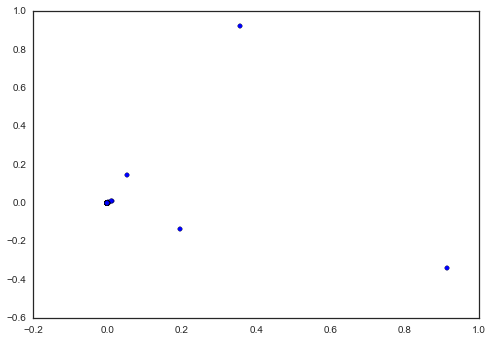

In [10]:
plt.scatter(pca.components_[0],pca.components_[1])

In [12]:
# lasso regression
# Decision tree regressor
# random forest regressor

# look at reisduals more 
bd_pca = pd.DataFrame(data=pca.transform(bd[features]), columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4'])

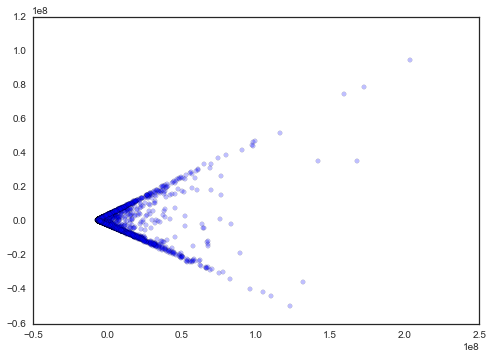

In [18]:
bd2 = bd_pca  #[bd_pca.PCA_1 < 0]
plt.scatter(bd2.PCA_1, bd2.PCA_2, alpha=0.25)

In [ ]:
# clustering using guassian distance based on where outliers are 

In [48]:
# random forest regressors (10 as test 500 max overnight)

In [ ]:
# 3what doesn't matter


In [24]:
bd.property_type.unique()

array(['Office', 'Multifamily Housing', 'Bank/Financial Institution',
       'Hotel', 'Retail', 'House of Worship', 'Other', 'K-12 School',
       'Warehouse (Unrefrigerated)', 'Residence Hall/Dormitory',
       'College/University (Campus-Level)', 'Medical Office',
       'Senior Care Facility', 'Self-Storage', 'Lodging',
       'Entertainment/Culture', 'Recreation', 'Library',
       'Clinic/Other Outpatient Health', 'Warehouse (Refrigerated)',
       'Retail (Misc)', 'Hospital (General Medical and Surgical)',
       'Education', 'Storage/Shipping/Non-Refrigerated Warehouse',
       'Automobile Dealership', 'Social/Meeting', 'Supermarket/Grocery',
       'Public Assembly',
       'Service (Vehicle Repair/Service, Postal Service)',
       'Health Care: Outpatient', 'Mall (Strip Mall and Enclosed)',
       "Health Care: Inpatient (Specialty Hospitals, Excluding Children's)",
       nan, 'Food Sales', 'Data Center', 'Retail Store'], dtype=object)